In [298]:
import pandas as pd
from konlpy.tag import Kkma
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import transformers
from konlpy.tag import Mecab
from collections import Counter

In [299]:
# matplotlib 한글 패치
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': # Mac
    rc('font', family='AppleGothic')
else: #linux
    rc('font', family='NanumGothic')

In [300]:
# .. 상위 폴더
train_pd = pd.read_csv('../../../../data/train.csv')
train_pd

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
9319,boostcamp-sts-v1-train-9319,petition-sampled,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,0.2,0.0
9320,boostcamp-sts-v1-train-9320,petition-sampled,여성가족부의 폐지를 원합니드,여성가족부 폐지를 청원 합니다.,4.2,1.0
9321,boostcamp-sts-v1-train-9321,petition-sampled,국회의원들 월급좀 줄여주세요,공무원 봉급좀 줄이지좀 마세요,0.6,0.0
9322,boostcamp-sts-v1-train-9322,slack-sampled,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,3.2,1.0


In [301]:
# apply 함수로 일괄 적용

# sentence 합치기
train_pd['sentence_a'] = train_pd['sentence_1'] + ' ' + train_pd['sentence_2']

# 공백 기준으로 토큰 나누기
train_pd['tokens_a']=train_pd['sentence_a'].apply(lambda x: x.split())
train_pd['tokens_1']=train_pd['sentence_1'].apply(lambda x: x.split())
train_pd['tokens_2']=train_pd['sentence_2'].apply(lambda x: x.split())

# 문장 길이, 토큰 개수 칼럼 만들기
train_pd['sen_len_a']=train_pd['sentence_a'].apply(lambda x: len(x))
train_pd['sen_len_1']=train_pd['sentence_1'].apply(lambda x: len(x))
train_pd['sen_len_2']=train_pd['sentence_2'].apply(lambda x: len(x))

train_pd['tok_count_a']=train_pd['tokens_a'].apply(lambda x: len(x))
train_pd['tok_count_1']=train_pd['tokens_1'].apply(lambda x: len(x))
train_pd['tok_count_2']=train_pd['tokens_2'].apply(lambda x: len(x))

# label 단순화, 소숫점 버림
train_pd['simple_label'] = train_pd['label'].apply(lambda x: int(x))

train_pd.head()

,id,source,sentence_1,sentence_2,label,binary-label,sentence_a,tokens_a,tokens_1,tokens_2,sen_len_a,sen_len_1,sen_len_2,tok_count_a,tok_count_1,tok_count_2,simple_label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0,"스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~ 반전도 있고,...","[스릴도있고, 반전도, 있고, 여느, 한국영화, 쓰레기들하고는, 차원이, 다르네요~...","[스릴도있고, 반전도, 있고, 여느, 한국영화, 쓰레기들하고는, 차원이, 다르네요~]","[반전도, 있고,사랑도, 있고재미도있네요.]",59,38,20,11,8,3,2
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0,"앗 제가 접근권한이 없다고 뜹니다;; 오, 액세스 권한이 없다고 합니다.","[앗, 제가, 접근권한이, 없다고, 뜹니다;;, 오,, 액세스, 권한이, 없다고, ...","[앗, 제가, 접근권한이, 없다고, 뜹니다;;]","[오,, 액세스, 권한이, 없다고, 합니다.]",40,20,19,10,5,5,4
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0,주택청약조건 변경해주세요. 주택청약 무주택기준 변경해주세요.,"[주택청약조건, 변경해주세요., 주택청약, 무주택기준, 변경해주세요.]","[주택청약조건, 변경해주세요.]","[주택청약, 무주택기준, 변경해주세요.]",33,14,18,5,2,3,2
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0,입사후 처음 대면으로 만나 반가웠습니다. 화상으로만 보다가 리얼로 만나니 정말 반가...,"[입사후, 처음, 대면으로, 만나, 반가웠습니다., 화상으로만, 보다가, 리얼로, ...","[입사후, 처음, 대면으로, 만나, 반가웠습니다.]","[화상으로만, 보다가, 리얼로, 만나니, 정말, 반가웠습니다.]",51,22,28,11,5,6,3
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0,뿌듯뿌듯 하네요!! 꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,"[뿌듯뿌듯, 하네요!!, 꼬옥, 실제로, 한번, 뵈어요, 뿌뿌뿌~!~!]","[뿌듯뿌듯, 하네요!!]","[꼬옥, 실제로, 한번, 뵈어요, 뿌뿌뿌~!~!]",32,10,21,7,2,5,0


In [302]:
tokenizer160 = transformers.AutoTokenizer.from_pretrained('klue/roberta-small')
tokenizer512 = transformers.AutoTokenizer.from_pretrained('klue/roberta-small', max_length=512)

In [303]:
df = train_pd.drop(columns=['id'])
data160 = []
for idx, item in tqdm(df.iterrows(), desc='tokenizing', total=len(df)):
# 두 입력 문장을 [SEP] 토큰으로 이어붙여서 전처리합니다.
    text = '[SEP]'.join([item[text_column] for text_column in ['sentence_1', 'sentence_2']])
    outputs = tokenizer160(text, add_special_tokens=True, padding='max_length', max_length=160, truncation=True)
    data160.append(outputs['input_ids'])

tokenizing:   0%|          | 0/9324 [00:00<?, ?it/s]

In [304]:
df = train_pd.drop(columns=['id'])
data512 = []
for idx, item in tqdm(df.iterrows(), desc='tokenizing', total=len(df)):
# 두 입력 문장을 [SEP] 토큰으로 이어붙여서 전처리합니다.
    text = '[SEP]'.join([item[text_column] for text_column in ['sentence_1', 'sentence_2']])
    outputs = tokenizer160(text, add_special_tokens=True, padding='max_length', truncation=True)
    data512.append(outputs['input_ids'])

tokenizing:   0%|          | 0/9324 [00:00<?, ?it/s]

In [305]:
print(len(data160[0]))
print(data160[0])

160
[0, 15314, 2119, 2689, 2088, 8984, 2119, 1513, 2088, 11934, 3629, 16516, 6614, 2031, 19521, 2259, 4540, 2052, 4405, 2203, 2182, 97, 2, 8984, 2119, 1513, 2088, 16, 3784, 2119, 1513, 2088, 2070, 2044, 2119, 2689, 2203, 2182, 18, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [306]:
print(len(data512[0]))
print(data512[0][:160])

512
[0, 15314, 2119, 2689, 2088, 8984, 2119, 1513, 2088, 11934, 3629, 16516, 6614, 2031, 19521, 2259, 4540, 2052, 4405, 2203, 2182, 97, 2, 8984, 2119, 1513, 2088, 16, 3784, 2119, 1513, 2088, 2070, 2044, 2119, 2689, 2203, 2182, 18, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [307]:
train_pd[train_pd['sen_len_a']==max(train_pd['sen_len_a'])]

,id,source,sentence_1,sentence_2,label,binary-label,sentence_a,tokens_a,tokens_1,tokens_2,sen_len_a,sen_len_1,sen_len_2,tok_count_a,tok_count_1,tok_count_2,simple_label
2412,boostcamp-sts-v1-train-2412,nsmc-rtt,‥ 김민희를알수록 의심되는 정체. 완벽한연기. 완벽한몰입과스릴. 작은반전. 무엇보다...,‥ 김민희를 알면 알수록 의심스러워진다. 완벽한 연기. 완벽한 몰입과 스릴. 작은 ...,4.0,1.0,‥ 김민희를알수록 의심되는 정체. 완벽한연기. 완벽한몰입과스릴. 작은반전. 무엇보다...,"[‥, 김민희를알수록, 의심되는, 정체., 완벽한연기., 완벽한몰입과스릴., 작은반...","[‥, 김민희를알수록, 의심되는, 정체., 완벽한연기., 완벽한몰입과스릴., 작은반...","[‥, 김민희를, 알면, 알수록, 의심스러워진다., 완벽한, 연기., 완벽한, 몰입...",209,94,114,43,17,26,4


In [308]:
print(len(data160[2412]))
print(data160[0][:250])

160
[0, 15314, 2119, 2689, 2088, 8984, 2119, 1513, 2088, 11934, 3629, 16516, 6614, 2031, 19521, 2259, 4540, 2052, 4405, 2203, 2182, 97, 2, 8984, 2119, 1513, 2088, 16, 3784, 2119, 1513, 2088, 2070, 2044, 2119, 2689, 2203, 2182, 18, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [309]:
print(len(data512[2412]))
print(data512[0][:250])

512
[0, 15314, 2119, 2689, 2088, 8984, 2119, 1513, 2088, 11934, 3629, 16516, 6614, 2031, 19521, 2259, 4540, 2052, 4405, 2203, 2182, 97, 2, 8984, 2119, 1513, 2088, 16, 3784, 2119, 1513, 2088, 2070, 2044, 2119, 2689, 2203, 2182, 18, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Tokenizer max_length 자료 조사

- 우선, 실험적으로 max_length 변화에 차이가 존재하지 않았음
- Tokenzier 호출 시 max_length는 truncation/padding 의 maximum length를 control
- Padding에 들어간 'max_length'는 model의 최대 수용 가능 입력 길이를 의미하며 이것을 사용하면 해당 길이까지 padding 처리해줌
    - ![Tokenizer max_length Description](../../../src/max_length_d.png) 
    - ![Padding max_length Description](../../../src/padding_d.png)  
    - [Hugging Face tokenzier doc](https://huggingface.co/docs/transformers/main_classes/tokenizer)
    - [Hugging Face pad_trunc doc](https://huggingface.co/docs/transformers/pad_truncation)
    #
- 사용한 Tokenizer는 [BertTokenizer](https://huggingface.co/klue/roberta-small/blob/main/tokenizer_config.json)
- 아래는 관련 문서
    - [AutoTokenzier Source Code](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#autotokenizer)
    - [AutoConfig Source Code](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#autoconfig)
    - [BertConfig 문서](https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#transformers.BertConfig)

In [316]:
tokenizer = transformers.AutoTokenizer.from_pretrained('klue/roberta-small')
df = train_pd.drop(columns=['id'])
data = []
for idx, item in tqdm(df.iterrows(), desc='tokenizing', total=len(df)):
# 두 입력 문장을 [SEP] 토큰으로 이어붙여서 전처리합니다.
    text = '[SEP]'.join([item[text_column] for text_column in ['sentence_1', 'sentence_2']])
    outputs = tokenizer(text, add_special_tokens=True, padding='do_not_pad', truncation=True)
    data.append(outputs['input_ids'])

tokenizing:   0%|          | 0/9324 [00:00<?, ?it/s]

In [317]:
max(list(map(lambda x : len(x), data)))

171

In [318]:
''.join(tokenizer.batch_decode(data[0][:150]))

'[CLS]스릴##도##있##고반전##도있##고여느한국##영화쓰레기##들##하고##는차원##이다르##네##요~[SEP]반전##도있##고,사랑##도있##고##재##미##도##있##네##요.[SEP]'

In [319]:
''.join(tokenizer.batch_decode(data[2412][:150]))

'[CLS]‥김민##희##를##알##수록의심##되##는정체.완벽##한##연##기.완벽##한##몰##입##과##스##릴.작##은##반##전.무엇##보##다현실##성이##있##는‥인간##의한계##와그걸벗어나##려##는욕심##을##보##여##준‥내보##기##엔완벽##한시나리오.[SEP]‥김민##희##를알##면알##수록의심##스##러워##진다.완벽##한연기.완벽##한몰입##과스릴.작##은회전.무엇##보##다현실##적인시나리오##다.인간##의한계##와그것##을벗어나##고##자하##는욕망##을보여준다.시나리오##가완벽##했##던것같##다.[SEP]'

In [147]:
train_pd['bert_tokenized']=pd.Series(map(lambda x : ''.join(tokenizer.batch_decode(x)),data))

In [148]:
samp_pd = train_pd[['sentence_1','sentence_2','sentence_a','bert_tokenized','label']]
samp_pd

,sentence_1,sentence_2,sentence_a,bert_tokenized,label
0,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.","스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~ 반전도 있고,...",[CLS]스릴##도##있##고반전##도있##고여느한국##영화쓰레기##들##하고##는...,2.2
1,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.","앗 제가 접근권한이 없다고 뜹니다;; 오, 액세스 권한이 없다고 합니다.","[CLS]앗제##가접근##권##한##이없##다고[UNK];;[SEP]오,액세##스권...",4.2
2,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요. 주택청약 무주택기준 변경해주세요.,[CLS]주택##청##약##조건변경##해##주##세요.[SEP]주택##청##약무주택...,2.4
3,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다. 화상으로만 보다가 리얼로 만나니 정말 반가...,[CLS]입사##후처음대면##으로만나반가웠##습##니다.[SEP]화상##으로##만보...,3.0
4,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,뿌듯뿌듯 하네요!! 꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,[CLS]뿌듯##뿌##듯하##네##요!![SEP]꼬##옥실제로한번뵈##어요뿌##뿌#...,0.0
...,...,...,...,...,...
9319,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다 본인이 납부한 국...,[CLS]교원##능력##개발##평가##에서교원##이보호##받##을수있##는장치##를...,0.2
9320,여성가족부의 폐지를 원합니드,여성가족부 폐지를 청원 합니다.,여성가족부의 폐지를 원합니드 여성가족부 폐지를 청원 합니다.,[CLS]여성##가족##부##의폐지##를원##합##니##드[SEP]여성##가족##부...,4.2
9321,국회의원들 월급좀 줄여주세요,공무원 봉급좀 줄이지좀 마세요,국회의원들 월급좀 줄여주세요 공무원 봉급좀 줄이지좀 마세요,[CLS]국회의원##들월급##좀줄여##주##세요[SEP]공무원봉급##좀줄이##지##...,0.6
9322,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!! 오늘 못먹은 밥은 꼭 담에 먹...,[CLS]오늘못한점심##은다음##에다시츄##라이하##기##로해요!![SEP]오늘못#...,3.2


In [149]:
kkma = Kkma()
samp_pd['bert_pos']= samp_pd['bert_tokenized'].apply(lambda x: kkma.pos(x.replace('##',' ')))

c:\Users\kzvxy\.conda\envs\proyum\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [150]:
samp_pd

,sentence_1,sentence_2,sentence_a,bert_tokenized,label,bert_pos
0,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.","스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~ 반전도 있고,...",[CLS]스릴##도##있##고반전##도있##고여느한국##영화쓰레기##들##하고##는...,2.2,"[([, SS), (CLS, OL), (], SS), (스리, VA), (ㄹ, ET..."
1,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.","앗 제가 접근권한이 없다고 뜹니다;; 오, 액세스 권한이 없다고 합니다.","[CLS]앗제##가접근##권##한##이없##다고[UNK];;[SEP]오,액세##스권...",4.2,"[([, SS), (CLS, OL), (], SS), (앗, IC), (저, NP)..."
2,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요. 주택청약 무주택기준 변경해주세요.,[CLS]주택##청##약##조건변경##해##주##세요.[SEP]주택##청##약무주택...,2.4,"[([, SS), (CLS, OL), (], SS), (주택, NNG), (청, N..."
3,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다. 화상으로만 보다가 리얼로 만나니 정말 반가...,[CLS]입사##후처음대면##으로만나반가웠##습##니다.[SEP]화상##으로##만보...,3.0,"[([, SS), (CLS, OL), (], SS), (입사, NNG), (후, N..."
4,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,뿌듯뿌듯 하네요!! 꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,[CLS]뿌듯##뿌##듯하##네##요!![SEP]꼬##옥실제로한번뵈##어요뿌##뿌#...,0.0,"[([, SS), (CLS, OL), (], SS), (뿌듯, XR), (뿔, VV..."
...,...,...,...,...,...,...
9319,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다 본인이 납부한 국...,[CLS]교원##능력##개발##평가##에서교원##이보호##받##을수있##는장치##를...,0.2,"[([, SS), (CLS, OL), (], SS), (교원, NNG), (능력, ..."
9320,여성가족부의 폐지를 원합니드,여성가족부 폐지를 청원 합니다.,여성가족부의 폐지를 원합니드 여성가족부 폐지를 청원 합니다.,[CLS]여성##가족##부##의폐지##를원##합##니##드[SEP]여성##가족##부...,4.2,"[([, SS), (CLS, OL), (], SS), (여성, NNG), (가족, ..."
9321,국회의원들 월급좀 줄여주세요,공무원 봉급좀 줄이지좀 마세요,국회의원들 월급좀 줄여주세요 공무원 봉급좀 줄이지좀 마세요,[CLS]국회의원##들월급##좀줄여##주##세요[SEP]공무원봉급##좀줄이##지##...,0.6,"[([, SS), (CLS, OL), (], SS), (국회, NNG), (의원, ..."
9322,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!! 오늘 못먹은 밥은 꼭 담에 먹...,[CLS]오늘못한점심##은다음##에다시츄##라이하##기##로해요!![SEP]오늘못#...,3.2,"[([, SS), (CLS, OL), (], SS), (오늘, NNG), (못하, ..."


In [151]:
samp_pd['bert_pos'][0][:20]

[('[', 'SS'),
 ('CLS', 'OL'),
 (']', 'SS'),
 ('스리', 'VA'),
 ('ㄹ', 'ETD'),
 ('도', 'NNG'),
 ('있', 'VX'),
 ('고', 'ECE'),
 ('반전', 'NNG'),
 ('도있', 'UN'),
 ('고', 'ECE'),
 ('여느', 'MDT'),
 ('한국', 'NNG'),
 ('영화', 'NNG'),
 ('쓰레기', 'NNG'),
 ('들', 'NNG'),
 ('하', 'VV'),
 ('고', 'ECE'),
 ('늘', 'VV'),
 ('ㄴ', 'ETD')]

In [152]:
pd.DataFrame([kkma.pos(samp_pd['sentence_1'][0]),kkma.pos(samp_pd['sentence_2'][0])])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"(스릴, NNG)","(도, JX)","(있, VV)","(고, ECE)","(반전, NNG)","(도, JX)","(있, VV)","(고, ECE)","(여느, MDT)","(한국, NNG)","(영화, NNG)","(쓰레기, NNG)","(들, XSN)","(하, VV)","(고는, ECE)","(차원, NNG)","(이, JKS)","(다르, VA)","(네요, EFN)","(~, SO)"
1,"(반전, NNG)","(도, JX)","(있, VV)","(고, ECE)","(,, SP)","(사랑, NNG)","(도, JX)","(있, VV)","(고, ECE)","(재미, NNG)","(도, JX)","(있, VV)","(네요, EFN)","(., SF)",None,None,None,None,None,None


In [323]:
from numpy import NaN
samp_pd['pos_sen_1'] = samp_pd['sentence_1'].apply(lambda x: kkma.pos(x))
dl = []
for i in range(len(samp_pd)):
    try:
        dl.append(kkma.pos(samp_pd['sentence_2'][i]))
    except:
        dl.append([NaN])
        print(i)
samp_pd['pos_sen_2'] = dl

c:\Users\kzvxy\.conda\envs\proyum\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


387


c:\Users\kzvxy\.conda\envs\proyum\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [329]:
samp_pd[samp_pd.index==387]['bert_tokenized']

,sentence_1,sentence_2,sentence_a,bert_tokenized,label,bert_pos,pos_sen_1,pos_sen_2,pos_count_1,pos_count_2,p1_sen_1,p2_sen_2,p1_count_1,p1_count_2
387,퐈이야!! 잘 마치시고 재충전타임 꼭 가지셨으면 좋겠어요~,👌👌👌👌 좋은 시간 보내시고 재충전의 시간 되시기 바랍니다!,퐈이야!! 잘 마치시고 재충전타임 꼭 가지셨으면 좋겠어요~ 👌👌👌👌 좋은 시간 보내...,[CLS][UNK]!!잘마치##시고재충전##타임꼭가지##셨##으면좋##겠##어요~[...,2.2,"[([, SS), (CLS, OL), (], SS), ([, SS), (UNK, O...","[(퐈이, UN), (야, JX), (!!, SW), (잘, MAG), (마치, V...",[nan],"{'UN': 1, 'JX': 1, 'SW': 1, 'MAG': 2, 'VV': 2,...",[nan],<generator object <lambda>.<locals>.<genexpr> ...,[nan],"{'U': 1, 'J': 1, 'S': 2, 'M': 2, 'V': 3, 'E': ...",{}


In [340]:
samp_pd[samp_pd.index==387]['bert_tokenized'].values

array(['[CLS][UNK]!!잘마치##시고재충전##타임꼭가지##셨##으면좋##겠##어요~[SEP][UNK]좋##은시간보내##시고재충전##의시간되##시##기바랍니다![SEP]'],
      dtype=object)

In [154]:
samp_pd

,sentence_1,sentence_2,sentence_a,bert_tokenized,label,bert_pos,pos_sen_1,pos_sen_2
0,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.","스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~ 반전도 있고,...",[CLS]스릴##도##있##고반전##도있##고여느한국##영화쓰레기##들##하고##는...,2.2,"[([, SS), (CLS, OL), (], SS), (스리, VA), (ㄹ, ET...","[(스릴, NNG), (도, JX), (있, VV), (고, ECE), (반전, N...","[(반전, NNG), (도, JX), (있, VV), (고, ECE), (,, SP..."
1,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.","앗 제가 접근권한이 없다고 뜹니다;; 오, 액세스 권한이 없다고 합니다.","[CLS]앗제##가접근##권##한##이없##다고[UNK];;[SEP]오,액세##스권...",4.2,"[([, SS), (CLS, OL), (], SS), (앗, IC), (저, NP)...","[(앗, IC), (저, NP), (가, JKS), (접근, NNG), (권한, N...","[(오, NNG), (,, SP), (액세스, NNG), (권한, NNG), (이,..."
2,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요. 주택청약 무주택기준 변경해주세요.,[CLS]주택##청##약##조건변경##해##주##세요.[SEP]주택##청##약무주택...,2.4,"[([, SS), (CLS, OL), (], SS), (주택, NNG), (청, N...","[(주택, NNG), (청약, NNG), (조건, NNG), (변경, NNG), (...","[(주택, NNG), (청약, NNG), (무, NNG), (주택, NNG), (기..."
3,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다. 화상으로만 보다가 리얼로 만나니 정말 반가...,[CLS]입사##후처음대면##으로만나반가웠##습##니다.[SEP]화상##으로##만보...,3.0,"[([, SS), (CLS, OL), (], SS), (입사, NNG), (후, N...","[(입사, NNG), (후, NNG), (처음, NNG), (대면, NNG), (으...","[(화상, NNG), (으로, JKM), (만, JX), (보, VV), (다가, ..."
4,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,뿌듯뿌듯 하네요!! 꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,[CLS]뿌듯##뿌##듯하##네##요!![SEP]꼬##옥실제로한번뵈##어요뿌##뿌#...,0.0,"[([, SS), (CLS, OL), (], SS), (뿌듯, XR), (뿔, VV...","[(뿌듯, XR), (뿌듯, XR), (하, VV), (네요, EFN), (!!, ...","[(꼬옥, MAG), (실제로, MAG), (한번, NNG), (뵈, VV), (어..."
...,...,...,...,...,...,...,...,...
9319,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다 본인이 납부한 국...,[CLS]교원##능력##개발##평가##에서교원##이보호##받##을수있##는장치##를...,0.2,"[([, SS), (CLS, OL), (], SS), (교원, NNG), (능력, ...","[(교원, NNG), (능력, NNG), (개발, NNG), (평가, NNG), (...","[(본인, NNG), (이, JKS), (납부, NNG), (하, XSV), (ㄴ,..."
9320,여성가족부의 폐지를 원합니드,여성가족부 폐지를 청원 합니다.,여성가족부의 폐지를 원합니드 여성가족부 폐지를 청원 합니다.,[CLS]여성##가족##부##의폐지##를원##합##니##드[SEP]여성##가족##부...,4.2,"[([, SS), (CLS, OL), (], SS), (여성, NNG), (가족, ...","[(여성, NNG), (가족, NNG), (부의, NNG), (폐지, NNG), (...","[(여성, NNG), (가족, NNG), (부, NNG), (폐지, NNG), (를..."
9321,국회의원들 월급좀 줄여주세요,공무원 봉급좀 줄이지좀 마세요,국회의원들 월급좀 줄여주세요 공무원 봉급좀 줄이지좀 마세요,[CLS]국회의원##들월급##좀줄여##주##세요[SEP]공무원봉급##좀줄이##지##...,0.6,"[([, SS), (CLS, OL), (], SS), (국회, NNG), (의원, ...","[(국회의원, NNG), (들, XSN), (월급, NNG), (좀, MAG), (...","[(공무원, NNG), (봉급, NNG), (좀, MAG), (줄이, VV), (지..."
9322,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!! 오늘 못먹은 밥은 꼭 담에 먹...,[CLS]오늘못한점심##은다음##에다시츄##라이하##기##로해요!![SEP]오늘못#...,3.2,"[([, SS), (CLS, OL), (], SS), (오늘, NNG), (못하, ...","[(오늘, NNG), (못하, VA), (ㄴ, ETD), (점심, NNG), (은,...","[(오늘, NNG), (못, MAG), (먹, VV), (은, ETD), (밥, N..."


In [155]:
samp_pd.head(5)

,sentence_1,sentence_2,sentence_a,bert_tokenized,label,bert_pos,pos_sen_1,pos_sen_2
0,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.","스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~ 반전도 있고,...",[CLS]스릴##도##있##고반전##도있##고여느한국##영화쓰레기##들##하고##는...,2.2,"[([, SS), (CLS, OL), (], SS), (스리, VA), (ㄹ, ET...","[(스릴, NNG), (도, JX), (있, VV), (고, ECE), (반전, N...","[(반전, NNG), (도, JX), (있, VV), (고, ECE), (,, SP..."
1,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.","앗 제가 접근권한이 없다고 뜹니다;; 오, 액세스 권한이 없다고 합니다.","[CLS]앗제##가접근##권##한##이없##다고[UNK];;[SEP]오,액세##스권...",4.2,"[([, SS), (CLS, OL), (], SS), (앗, IC), (저, NP)...","[(앗, IC), (저, NP), (가, JKS), (접근, NNG), (권한, N...","[(오, NNG), (,, SP), (액세스, NNG), (권한, NNG), (이,..."
2,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요. 주택청약 무주택기준 변경해주세요.,[CLS]주택##청##약##조건변경##해##주##세요.[SEP]주택##청##약무주택...,2.4,"[([, SS), (CLS, OL), (], SS), (주택, NNG), (청, N...","[(주택, NNG), (청약, NNG), (조건, NNG), (변경, NNG), (...","[(주택, NNG), (청약, NNG), (무, NNG), (주택, NNG), (기..."
3,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다. 화상으로만 보다가 리얼로 만나니 정말 반가...,[CLS]입사##후처음대면##으로만나반가웠##습##니다.[SEP]화상##으로##만보...,3.0,"[([, SS), (CLS, OL), (], SS), (입사, NNG), (후, N...","[(입사, NNG), (후, NNG), (처음, NNG), (대면, NNG), (으...","[(화상, NNG), (으로, JKM), (만, JX), (보, VV), (다가, ..."
4,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,뿌듯뿌듯 하네요!! 꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,[CLS]뿌듯##뿌##듯하##네##요!![SEP]꼬##옥실제로한번뵈##어요뿌##뿌#...,0.0,"[([, SS), (CLS, OL), (], SS), (뿌듯, XR), (뿔, VV...","[(뿌듯, XR), (뿌듯, XR), (하, VV), (네요, EFN), (!!, ...","[(꼬옥, MAG), (실제로, MAG), (한번, NNG), (뵈, VV), (어..."


In [156]:
Counter(b for a,b in samp_pd['pos_sen_1'][0])

Counter({'NNG': 6,
         'JX': 2,
         'VV': 3,
         'ECE': 3,
         'MDT': 1,
         'XSN': 1,
         'JKS': 1,
         'VA': 1,
         'EFN': 1,
         'SO': 1})

In [157]:
len(samp_pd)

9324

In [158]:
len(samp_pd['pos_sen_2'])

9324

In [159]:
dl1 = []
dl2 = []
for i in range(len(samp_pd)):
    try:
        dl1.append(Counter(b for a,b in samp_pd['pos_sen_1'][i]))
    except:
        dl1.append([NaN])
    try:
        dl2.append(Counter(b for a,b in samp_pd['pos_sen_2'][i]))
    except:
        dl2.append([NaN])
samp_pd['pos_count_1']=dl1
samp_pd['pos_count_2']=dl2

c:\Users\kzvxy\.conda\envs\proyum\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
c:\Users\kzvxy\.conda\envs\proyum\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [160]:
samp_pd

,sentence_1,sentence_2,sentence_a,bert_tokenized,label,bert_pos,pos_sen_1,pos_sen_2,pos_count_1,pos_count_2
0,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.","스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~ 반전도 있고,...",[CLS]스릴##도##있##고반전##도있##고여느한국##영화쓰레기##들##하고##는...,2.2,"[([, SS), (CLS, OL), (], SS), (스리, VA), (ㄹ, ET...","[(스릴, NNG), (도, JX), (있, VV), (고, ECE), (반전, N...","[(반전, NNG), (도, JX), (있, VV), (고, ECE), (,, SP...","{'NNG': 6, 'JX': 2, 'VV': 3, 'ECE': 3, 'MDT': ...","{'NNG': 3, 'JX': 3, 'VV': 3, 'ECE': 2, 'SP': 1..."
1,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.","앗 제가 접근권한이 없다고 뜹니다;; 오, 액세스 권한이 없다고 합니다.","[CLS]앗제##가접근##권##한##이없##다고[UNK];;[SEP]오,액세##스권...",4.2,"[([, SS), (CLS, OL), (], SS), (앗, IC), (저, NP)...","[(앗, IC), (저, NP), (가, JKS), (접근, NNG), (권한, N...","[(오, NNG), (,, SP), (액세스, NNG), (권한, NNG), (이,...","{'IC': 1, 'NP': 1, 'JKS': 2, 'NNG': 2, 'VA': 1...","{'NNG': 3, 'SP': 1, 'JKS': 1, 'VA': 1, 'ECE': ..."
2,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요. 주택청약 무주택기준 변경해주세요.,[CLS]주택##청##약##조건변경##해##주##세요.[SEP]주택##청##약무주택...,2.4,"[([, SS), (CLS, OL), (], SS), (주택, NNG), (청, N...","[(주택, NNG), (청약, NNG), (조건, NNG), (변경, NNG), (...","[(주택, NNG), (청약, NNG), (무, NNG), (주택, NNG), (기...","{'NNG': 4, 'XSV': 1, 'ECS': 1, 'VXV': 1, 'EFN'...","{'NNG': 6, 'XSV': 1, 'ECS': 1, 'VXV': 1, 'EFN'..."
3,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다. 화상으로만 보다가 리얼로 만나니 정말 반가...,[CLS]입사##후처음대면##으로만나반가웠##습##니다.[SEP]화상##으로##만보...,3.0,"[([, SS), (CLS, OL), (], SS), (입사, NNG), (후, N...","[(입사, NNG), (후, NNG), (처음, NNG), (대면, NNG), (으...","[(화상, NNG), (으로, JKM), (만, JX), (보, VV), (다가, ...","{'NNG': 4, 'JKM': 1, 'JX': 1, 'NP': 1, 'VA': 1...","{'NNG': 2, 'JKM': 2, 'JX': 1, 'VV': 2, 'ECD': ..."
4,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,뿌듯뿌듯 하네요!! 꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,[CLS]뿌듯##뿌##듯하##네##요!![SEP]꼬##옥실제로한번뵈##어요뿌##뿌#...,0.0,"[([, SS), (CLS, OL), (], SS), (뿌듯, XR), (뿔, VV...","[(뿌듯, XR), (뿌듯, XR), (하, VV), (네요, EFN), (!!, ...","[(꼬옥, MAG), (실제로, MAG), (한번, NNG), (뵈, VV), (어...","{'XR': 2, 'VV': 1, 'EFN': 1, 'SW': 1}","{'MAG': 2, 'NNG': 1, 'VV': 1, 'EFN': 1, 'UN': ..."
...,...,...,...,...,...,...,...,...,...,...
9319,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다 본인이 납부한 국...,[CLS]교원##능력##개발##평가##에서교원##이보호##받##을수있##는장치##를...,0.2,"[([, SS), (CLS, OL), (], SS), (교원, NNG), (능력, ...","[(교원, NNG), (능력, NNG), (개발, NNG), (평가, NNG), (...","[(본인, NNG), (이, JKS), (납부, NNG), (하, XSV), (ㄴ,...","{'NNG': 8, 'JKM': 1, 'JKS': 1, 'VV': 3, 'ETD':...","{'NNG': 9, 'JKS': 1, 'XSV': 2, 'ETD': 3, 'JKO'..."
9320,여성가족부의 폐지를 원합니드,여성가족부 폐지를 청원 합니다.,여성가족부의 폐지를 원합니드 여성가족부 폐지를 청원 합니다.,[CLS]여성##가족##부##의폐지##를원##합##니##드[SEP]여성##가족##부...,4.2,"[([, SS), (CLS, OL), (], SS), (여성, NNG), (가족, ...","[(여성, NNG), (가족, NNG), (부의, NNG), (폐지, NNG), (...","[(여성, NNG), (가족, NNG), (부, NNG), (폐지, NNG), (를...","{'NNG': 6, 'JKO': 1, 'NP': 1, 'VV': 1}","{'NNG': 5, 'JKO': 1, 'VV': 1, 'EFN': 1, 'SF': 1}"
9321,국회의원들 월급좀 줄여주세요,공무원 봉급좀 줄이지좀 마세요,국회의원들 월급좀 줄여주세요 공무원 봉급좀 줄이지좀 마세요,[CLS]국회의원##들월급##좀줄여##주##세요[SEP]공무원봉급##좀줄이##지##...,0.6,"[([, SS), (CLS, OL), (], SS), (국회, NNG), (의원, ...","[(국회의원, NNG), (들, XSN), (월급, NNG), (좀, MAG), (...","[(공무원, NNG), (봉급, NNG), (좀, MAG), (줄이, VV), (지...","{'NNG': 2, 'XSN': 1, 'MAG': 1, 'VV': 1, 'ECS':...","{'NNG': 2, 'MAG': 2, 'VV': 2, 'ECD': 1, 'EFN': 1}"
9322,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!! 오늘 못먹은 밥은 꼭 담에 먹...,[CLS]오늘못한점심##은다음##에다시츄##라이하##기##로해요!![SEP]오늘못#...,3.2,"[([, SS), (CLS, OL), (], SS), (오늘, NNG), (못하, ...","[(오늘, NNG), (못하, VA), (ㄴ, ETD), (점심, NNG), (은,...","[(오늘, NNG), (못, MAG), (먹, VV), (은, ETD), (밥, N...","{'NNG': 5, 'VA': 1, 'ETD': 1, 'JX': 2, 'JKM': ...","{'NNG': 3, 'MAG': 2, 'VV': 2, 'ETD': 1, 'JX': ..."


In [161]:
samp_pd

,sentence_1,sentence_2,sentence_a,bert_tokenized,label,bert_pos,pos_sen_1,pos_sen_2,pos_count_1,pos_count_2
0,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.","스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~ 반전도 있고,...",[CLS]스릴##도##있##고반전##도있##고여느한국##영화쓰레기##들##하고##는...,2.2,"[([, SS), (CLS, OL), (], SS), (스리, VA), (ㄹ, ET...","[(스릴, NNG), (도, JX), (있, VV), (고, ECE), (반전, N...","[(반전, NNG), (도, JX), (있, VV), (고, ECE), (,, SP...","{'NNG': 6, 'JX': 2, 'VV': 3, 'ECE': 3, 'MDT': ...","{'NNG': 3, 'JX': 3, 'VV': 3, 'ECE': 2, 'SP': 1..."
1,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.","앗 제가 접근권한이 없다고 뜹니다;; 오, 액세스 권한이 없다고 합니다.","[CLS]앗제##가접근##권##한##이없##다고[UNK];;[SEP]오,액세##스권...",4.2,"[([, SS), (CLS, OL), (], SS), (앗, IC), (저, NP)...","[(앗, IC), (저, NP), (가, JKS), (접근, NNG), (권한, N...","[(오, NNG), (,, SP), (액세스, NNG), (권한, NNG), (이,...","{'IC': 1, 'NP': 1, 'JKS': 2, 'NNG': 2, 'VA': 1...","{'NNG': 3, 'SP': 1, 'JKS': 1, 'VA': 1, 'ECE': ..."
2,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요. 주택청약 무주택기준 변경해주세요.,[CLS]주택##청##약##조건변경##해##주##세요.[SEP]주택##청##약무주택...,2.4,"[([, SS), (CLS, OL), (], SS), (주택, NNG), (청, N...","[(주택, NNG), (청약, NNG), (조건, NNG), (변경, NNG), (...","[(주택, NNG), (청약, NNG), (무, NNG), (주택, NNG), (기...","{'NNG': 4, 'XSV': 1, 'ECS': 1, 'VXV': 1, 'EFN'...","{'NNG': 6, 'XSV': 1, 'ECS': 1, 'VXV': 1, 'EFN'..."
3,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다. 화상으로만 보다가 리얼로 만나니 정말 반가...,[CLS]입사##후처음대면##으로만나반가웠##습##니다.[SEP]화상##으로##만보...,3.0,"[([, SS), (CLS, OL), (], SS), (입사, NNG), (후, N...","[(입사, NNG), (후, NNG), (처음, NNG), (대면, NNG), (으...","[(화상, NNG), (으로, JKM), (만, JX), (보, VV), (다가, ...","{'NNG': 4, 'JKM': 1, 'JX': 1, 'NP': 1, 'VA': 1...","{'NNG': 2, 'JKM': 2, 'JX': 1, 'VV': 2, 'ECD': ..."
4,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,뿌듯뿌듯 하네요!! 꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,[CLS]뿌듯##뿌##듯하##네##요!![SEP]꼬##옥실제로한번뵈##어요뿌##뿌#...,0.0,"[([, SS), (CLS, OL), (], SS), (뿌듯, XR), (뿔, VV...","[(뿌듯, XR), (뿌듯, XR), (하, VV), (네요, EFN), (!!, ...","[(꼬옥, MAG), (실제로, MAG), (한번, NNG), (뵈, VV), (어...","{'XR': 2, 'VV': 1, 'EFN': 1, 'SW': 1}","{'MAG': 2, 'NNG': 1, 'VV': 1, 'EFN': 1, 'UN': ..."
...,...,...,...,...,...,...,...,...,...,...
9319,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다 본인이 납부한 국...,[CLS]교원##능력##개발##평가##에서교원##이보호##받##을수있##는장치##를...,0.2,"[([, SS), (CLS, OL), (], SS), (교원, NNG), (능력, ...","[(교원, NNG), (능력, NNG), (개발, NNG), (평가, NNG), (...","[(본인, NNG), (이, JKS), (납부, NNG), (하, XSV), (ㄴ,...","{'NNG': 8, 'JKM': 1, 'JKS': 1, 'VV': 3, 'ETD':...","{'NNG': 9, 'JKS': 1, 'XSV': 2, 'ETD': 3, 'JKO'..."
9320,여성가족부의 폐지를 원합니드,여성가족부 폐지를 청원 합니다.,여성가족부의 폐지를 원합니드 여성가족부 폐지를 청원 합니다.,[CLS]여성##가족##부##의폐지##를원##합##니##드[SEP]여성##가족##부...,4.2,"[([, SS), (CLS, OL), (], SS), (여성, NNG), (가족, ...","[(여성, NNG), (가족, NNG), (부의, NNG), (폐지, NNG), (...","[(여성, NNG), (가족, NNG), (부, NNG), (폐지, NNG), (를...","{'NNG': 6, 'JKO': 1, 'NP': 1, 'VV': 1}","{'NNG': 5, 'JKO': 1, 'VV': 1, 'EFN': 1, 'SF': 1}"
9321,국회의원들 월급좀 줄여주세요,공무원 봉급좀 줄이지좀 마세요,국회의원들 월급좀 줄여주세요 공무원 봉급좀 줄이지좀 마세요,[CLS]국회의원##들월급##좀줄여##주##세요[SEP]공무원봉급##좀줄이##지##...,0.6,"[([, SS), (CLS, OL), (], SS), (국회, NNG), (의원, ...","[(국회의원, NNG), (들, XSN), (월급, NNG), (좀, MAG), (...","[(공무원, NNG), (봉급, NNG), (좀, MAG), (줄이, VV), (지...","{'NNG': 2, 'XSN': 1, 'MAG': 1, 'VV': 1, 'ECS':...","{'NNG': 2, 'MAG': 2, 'VV': 2, 'ECD': 1, 'EFN': 1}"
9322,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!! 오늘 못먹은 밥은 꼭 담에 먹...,[CLS]오늘못한점심##은다음##에다시츄##라이하##기##로해요!![SEP]오늘못#...,3.2,"[([, SS), (CLS, OL), (], SS), (오늘, NNG), (못하, ...","[(오늘, NNG), (못하, VA), (ㄴ, ETD), (점심, NNG), (은,...","[(오늘, NNG), (못, MAG), (먹, VV), (은, ETD), (밥, N...","{'NNG': 5, 'VA': 1, 'ETD': 1, 'JX': 2, 'JKM': ...","{'NNG': 3, 'MAG': 2, 'VV': 2, 'ETD': 1, 'JX': ..."


In [ ]:
# samp_pd.to_csv('../../../../data/pos_train.csv')

In [195]:
kkma.__dict__['tagset']

{'EC': '연결 어미',
 'ECD': '의존적 연결 어미',
 'ECE': '대등 연결 어미',
 'ECS': '보조적 연결 어미',
 'EF': '종결 어미',
 'EFA': '청유형 종결 어미',
 'EFI': '감탄형 종결 어미',
 'EFN': '평서형 종결 어미',
 'EFO': '명령형 종결 어미',
 'EFQ': '의문형 종결 어미',
 'EFR': '존칭형 종결 어미',
 'EP': '선어말 어미',
 'EPH': '존칭 선어말 어미',
 'EPP': '공손 선어말 어미',
 'EPT': '시제 선어말 어미',
 'ET': '전성 어미',
 'ETD': '관형형 전성 어미',
 'ETN': '명사형 전성 어미',
 'IC': '감탄사',
 'JC': '접속 조사',
 'JK': '조사',
 'JKC': '보격 조사',
 'JKG': '관형격 조사',
 'JKI': '호격 조사',
 'JKM': '부사격 조사',
 'JKO': '목적격 조사',
 'JKQ': '인용격 조사',
 'JKS': '주격 조사',
 'JX': '보조사',
 'MA': '부사',
 'MAC': '접속 부사',
 'MAG': '일반 부사',
 'MD': '관형사',
 'MDN': '수 관형사',
 'MDT': '일반 관형사',
 'NN': '명사',
 'NNB': '일반 의존 명사',
 'NNG': '보통명사',
 'NNM': '단위 의존 명사',
 'NNP': '고유명사',
 'NP': '대명사',
 'NR': '수사',
 'OH': '한자',
 'OL': '외국어',
 'ON': '숫자',
 'SE': '줄임표',
 'SF': '마침표, 물음표, 느낌표',
 'SO': '붙임표(물결,숨김,빠짐)',
 'SP': '쉼표,가운뎃점,콜론,빗금',
 'SS': '따옴표,괄호표,줄표',
 'SW': '기타기호 (논리수학기호,화폐기호)',
 'UN': '명사추정범주',
 'VA': '형용사',
 'VC': '지정사',
 'VCN': "부정 지정사, 형용사 '아니다'",
 'VC

In [193]:
cols= list(kkma.__dict__['tagset'].keys())

['EC',
 'ECD',
 'ECE',
 'ECS',
 'EF',
 'EFA',
 'EFI',
 'EFN',
 'EFO',
 'EFQ',
 'EFR',
 'EP',
 'EPH',
 'EPP',
 'EPT',
 'ET',
 'ETD',
 'ETN',
 'IC',
 'JC',
 'JK',
 'JKC',
 'JKG',
 'JKI',
 'JKM',
 'JKO',
 'JKQ',
 'JKS',
 'JX',
 'MA',
 'MAC',
 'MAG',
 'MD',
 'MDN',
 'MDT',
 'NN',
 'NNB',
 'NNG',
 'NNM',
 'NNP',
 'NP',
 'NR',
 'OH',
 'OL',
 'ON',
 'SE',
 'SF',
 'SO',
 'SP',
 'SS',
 'SW',
 'UN',
 'VA',
 'VC',
 'VCN',
 'VCP',
 'VV',
 'VX',
 'VXA',
 'VXV',
 'XP',
 'XPN',
 'XPV',
 'XR',
 'XSA',
 'XSN',
 'XSV']

In [201]:
samp_pd['pos_count_1'][0]

Counter({'NNG': 6,
         'JX': 2,
         'VV': 3,
         'ECE': 3,
         'MDT': 1,
         'XSN': 1,
         'JKS': 1,
         'VA': 1,
         'EFN': 1,
         'SO': 1})

In [202]:
samp_pd

,sentence_1,sentence_2,sentence_a,bert_tokenized,label,bert_pos,pos_sen_1,pos_sen_2,pos_count_1,pos_count_2
0,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.","스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~ 반전도 있고,...",[CLS]스릴##도##있##고반전##도있##고여느한국##영화쓰레기##들##하고##는...,2.2,"[([, SS), (CLS, OL), (], SS), (스리, VA), (ㄹ, ET...","[(스릴, NNG), (도, JX), (있, VV), (고, ECE), (반전, N...","[(반전, NNG), (도, JX), (있, VV), (고, ECE), (,, SP...","{'NNG': 6, 'JX': 2, 'VV': 3, 'ECE': 3, 'MDT': ...","{'NNG': 3, 'JX': 3, 'VV': 3, 'ECE': 2, 'SP': 1..."
1,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.","앗 제가 접근권한이 없다고 뜹니다;; 오, 액세스 권한이 없다고 합니다.","[CLS]앗제##가접근##권##한##이없##다고[UNK];;[SEP]오,액세##스권...",4.2,"[([, SS), (CLS, OL), (], SS), (앗, IC), (저, NP)...","[(앗, IC), (저, NP), (가, JKS), (접근, NNG), (권한, N...","[(오, NNG), (,, SP), (액세스, NNG), (권한, NNG), (이,...","{'IC': 1, 'NP': 1, 'JKS': 2, 'NNG': 2, 'VA': 1...","{'NNG': 3, 'SP': 1, 'JKS': 1, 'VA': 1, 'ECE': ..."
2,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요. 주택청약 무주택기준 변경해주세요.,[CLS]주택##청##약##조건변경##해##주##세요.[SEP]주택##청##약무주택...,2.4,"[([, SS), (CLS, OL), (], SS), (주택, NNG), (청, N...","[(주택, NNG), (청약, NNG), (조건, NNG), (변경, NNG), (...","[(주택, NNG), (청약, NNG), (무, NNG), (주택, NNG), (기...","{'NNG': 4, 'XSV': 1, 'ECS': 1, 'VXV': 1, 'EFN'...","{'NNG': 6, 'XSV': 1, 'ECS': 1, 'VXV': 1, 'EFN'..."
3,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다. 화상으로만 보다가 리얼로 만나니 정말 반가...,[CLS]입사##후처음대면##으로만나반가웠##습##니다.[SEP]화상##으로##만보...,3.0,"[([, SS), (CLS, OL), (], SS), (입사, NNG), (후, N...","[(입사, NNG), (후, NNG), (처음, NNG), (대면, NNG), (으...","[(화상, NNG), (으로, JKM), (만, JX), (보, VV), (다가, ...","{'NNG': 4, 'JKM': 1, 'JX': 1, 'NP': 1, 'VA': 1...","{'NNG': 2, 'JKM': 2, 'JX': 1, 'VV': 2, 'ECD': ..."
4,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,뿌듯뿌듯 하네요!! 꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,[CLS]뿌듯##뿌##듯하##네##요!![SEP]꼬##옥실제로한번뵈##어요뿌##뿌#...,0.0,"[([, SS), (CLS, OL), (], SS), (뿌듯, XR), (뿔, VV...","[(뿌듯, XR), (뿌듯, XR), (하, VV), (네요, EFN), (!!, ...","[(꼬옥, MAG), (실제로, MAG), (한번, NNG), (뵈, VV), (어...","{'XR': 2, 'VV': 1, 'EFN': 1, 'SW': 1}","{'MAG': 2, 'NNG': 1, 'VV': 1, 'EFN': 1, 'UN': ..."
...,...,...,...,...,...,...,...,...,...,...
9319,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다 본인이 납부한 국...,[CLS]교원##능력##개발##평가##에서교원##이보호##받##을수있##는장치##를...,0.2,"[([, SS), (CLS, OL), (], SS), (교원, NNG), (능력, ...","[(교원, NNG), (능력, NNG), (개발, NNG), (평가, NNG), (...","[(본인, NNG), (이, JKS), (납부, NNG), (하, XSV), (ㄴ,...","{'NNG': 8, 'JKM': 1, 'JKS': 1, 'VV': 3, 'ETD':...","{'NNG': 9, 'JKS': 1, 'XSV': 2, 'ETD': 3, 'JKO'..."
9320,여성가족부의 폐지를 원합니드,여성가족부 폐지를 청원 합니다.,여성가족부의 폐지를 원합니드 여성가족부 폐지를 청원 합니다.,[CLS]여성##가족##부##의폐지##를원##합##니##드[SEP]여성##가족##부...,4.2,"[([, SS), (CLS, OL), (], SS), (여성, NNG), (가족, ...","[(여성, NNG), (가족, NNG), (부의, NNG), (폐지, NNG), (...","[(여성, NNG), (가족, NNG), (부, NNG), (폐지, NNG), (를...","{'NNG': 6, 'JKO': 1, 'NP': 1, 'VV': 1}","{'NNG': 5, 'JKO': 1, 'VV': 1, 'EFN': 1, 'SF': 1}"
9321,국회의원들 월급좀 줄여주세요,공무원 봉급좀 줄이지좀 마세요,국회의원들 월급좀 줄여주세요 공무원 봉급좀 줄이지좀 마세요,[CLS]국회의원##들월급##좀줄여##주##세요[SEP]공무원봉급##좀줄이##지##...,0.6,"[([, SS), (CLS, OL), (], SS), (국회, NNG), (의원, ...","[(국회의원, NNG), (들, XSN), (월급, NNG), (좀, MAG), (...","[(공무원, NNG), (봉급, NNG), (좀, MAG), (줄이, VV), (지...","{'NNG': 2, 'XSN': 1, 'MAG': 1, 'VV': 1, 'ECS':...","{'NNG': 2, 'MAG': 2, 'VV': 2, 'ECD': 1, 'EFN': 1}"
9322,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!! 오늘 못먹은 밥은 꼭 담에 먹...,[CLS]오늘못한점심##은다음##에다시츄##라이하##기##로해요!![SEP]오늘못#...,3.2,"[([, SS), (CLS, OL), (], SS), (오늘, NNG), (못하, ...","[(오늘, NNG), (못하, VA), (ㄴ, ETD), (점심, NNG), (은,...","[(오늘, NNG), (못, MAG), (먹, VV), (은, ETD), (밥, N...","{'NNG': 5, 'VA': 1, 'ETD': 1, 'JX': 2, 'JKM': ...","{'NNG': 3, 'MAG': 2, 'VV': 2, 'ETD': 1, 'JX': ..."


In [209]:
pd.DataFrame.from_records(samp_pd['pos_count_1'], columns=cols).fillna(0)

,EC,ECD,ECE,ECS,EF,EFA,EFI,EFN,EFO,EFQ,...,VX,VXA,VXV,XP,XPN,XPV,XR,XSA,XSN,XSV
0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9319,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9321,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9322,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
cols1 = list(set(map(lambda x : x[0] , kkma.__dict__['tagset'].keys())))
cols1

['U', 'S', 'E', 'V', 'O', 'J', 'X', 'M', 'I', 'N']

In [233]:
dl1 = []
dl2 = []
for i in range(len(samp_pd)):
    try:
        dl1.append(Counter(b[0] for a,b in samp_pd['pos_sen_1'][i]))
    except:
        dl1.append({})
    try:
        dl2.append(Counter(b[0] for a,b in samp_pd['pos_sen_2'][i]))
    except:
        dl2.append({})
samp_pd['p1_count_1']=dl1
samp_pd['p1_count_2']=dl2

c:\Users\kzvxy\.conda\envs\proyum\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
c:\Users\kzvxy\.conda\envs\proyum\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [234]:
samp_pd['p1_count_1']

0       {'N': 6, 'J': 3, 'V': 4, 'E': 4, 'M': 1, 'X': ...
1        {'I': 1, 'N': 3, 'J': 2, 'V': 2, 'E': 2, 'S': 1}
2                {'N': 4, 'X': 1, 'E': 2, 'V': 1, 'S': 1}
3                {'N': 5, 'J': 2, 'V': 1, 'E': 2, 'S': 1}
4                        {'X': 2, 'V': 1, 'E': 1, 'S': 1}
                              ...                        
9319             {'N': 9, 'J': 3, 'V': 3, 'E': 4, 'X': 1}
9320                             {'N': 7, 'J': 1, 'V': 1}
9321             {'N': 2, 'X': 1, 'M': 1, 'V': 2, 'E': 2}
9322    {'N': 5, 'V': 2, 'E': 2, 'J': 3, 'M': 1, 'U': ...
9323                                     {'N': 5, 'S': 2}
Name: p1_count_1, Length: 9324, dtype: object

In [235]:
p1 =pd.DataFrame.from_records(samp_pd['p1_count_1'], columns=cols1).fillna(0)
p1

,U,S,E,V,O,J,X,M,I,N
0,0.0,1.0,4.0,4.0,0.0,3.0,1.0,1.0,0.0,6.0
1,0.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,1.0,3.0
2,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0
3,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,5.0
4,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9319,0.0,0.0,4.0,3.0,0.0,3.0,1.0,0.0,0.0,9.0
9320,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,7.0
9321,0.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0
9322,1.0,1.0,2.0,2.0,0.0,3.0,0.0,1.0,0.0,5.0


In [254]:
p1.columns = list(map(lambda x: x+'_1', cols1))
p1

,U_1,S_1,E_1,V_1,O_1,J_1,X_1,M_1,I_1,N_1
0,0.0,1.0,4.0,4.0,0.0,3.0,1.0,1.0,0.0,6.0
1,0.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,1.0,3.0
2,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0
3,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,5.0
4,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9319,0.0,0.0,4.0,3.0,0.0,3.0,1.0,0.0,0.0,9.0
9320,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,7.0
9321,0.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0
9322,1.0,1.0,2.0,2.0,0.0,3.0,0.0,1.0,0.0,5.0


In [255]:
p2 = pd.DataFrame.from_records(samp_pd['p1_count_2'], columns=cols1).fillna(0)
# p2.columns = list(map(lambda x: x+'_2', cols1))
p2

,U,S,E,V,O,J,X,M,I,N
0,0.0,2.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,3.0
1,0.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,3.0
2,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,6.0
3,0.0,1.0,4.0,3.0,0.0,3.0,0.0,1.0,0.0,2.0
4,1.0,4.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
9319,0.0,0.0,5.0,3.0,0.0,5.0,2.0,0.0,0.0,10.0
9320,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0
9321,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0
9322,0.0,1.0,3.0,3.0,0.0,2.0,0.0,2.0,0.0,3.0


In [256]:
p2.columns = list(map(lambda x: x+'_2', cols1))
p2

,U_2,S_2,E_2,V_2,O_2,J_2,X_2,M_2,I_2,N_2
0,0.0,2.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,3.0
1,0.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,3.0
2,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,6.0
3,0.0,1.0,4.0,3.0,0.0,3.0,0.0,1.0,0.0,2.0
4,1.0,4.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
9319,0.0,0.0,5.0,3.0,0.0,5.0,2.0,0.0,0.0,10.0
9320,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0
9321,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0
9322,0.0,1.0,3.0,3.0,0.0,2.0,0.0,2.0,0.0,3.0


In [257]:
samp_pd['label']

0       2.2
1       4.2
2       2.4
3       3.0
4       0.0
       ... 
9319    0.2
9320    4.2
9321    0.6
9322    3.2
9323    1.4
Name: label, Length: 9324, dtype: float64

In [259]:
ppd = pd.concat([p1,p2,samp_pd['label']],axis=1)
ppd

,U_1,S_1,E_1,V_1,O_1,J_1,X_1,M_1,I_1,N_1,...,S_2,E_2,V_2,O_2,J_2,X_2,M_2,I_2,N_2,label
0,0.0,1.0,4.0,4.0,0.0,3.0,1.0,1.0,0.0,6.0,...,2.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,3.0,2.2
1,0.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,1.0,3.0,...,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,3.0,4.2
2,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,...,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,6.0,2.4
3,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,5.0,...,1.0,4.0,3.0,0.0,3.0,0.0,1.0,0.0,2.0,3.0
4,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,...,4.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9319,0.0,0.0,4.0,3.0,0.0,3.0,1.0,0.0,0.0,9.0,...,0.0,5.0,3.0,0.0,5.0,2.0,0.0,0.0,10.0,0.2
9320,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,7.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,4.2
9321,0.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0,...,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.6
9322,1.0,1.0,2.0,2.0,0.0,3.0,0.0,1.0,0.0,5.0,...,1.0,3.0,3.0,0.0,2.0,0.0,2.0,0.0,3.0,3.2


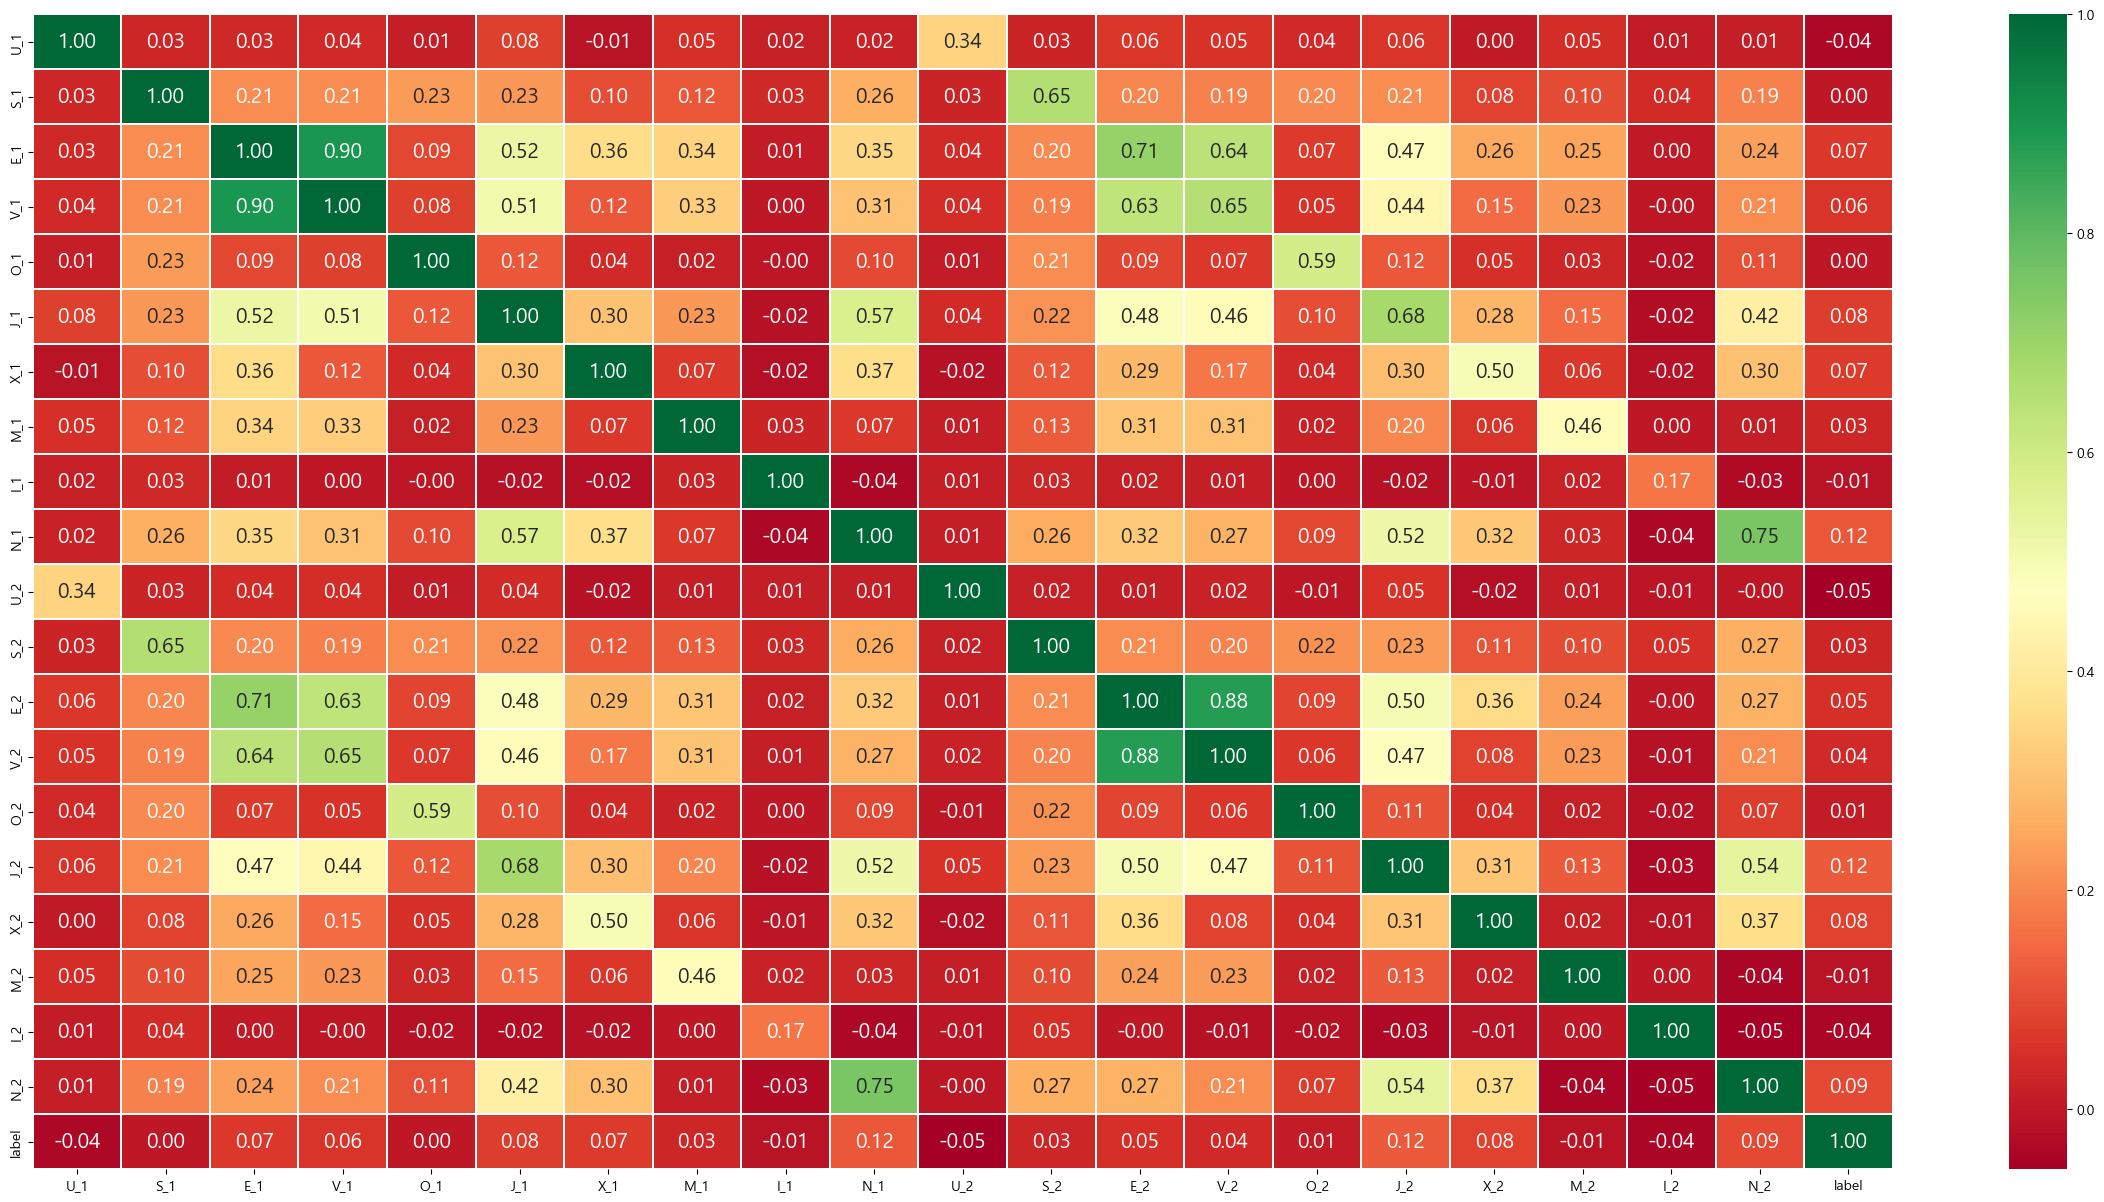

In [263]:
plt.figure(figsize=(30,15))
g=sns.heatmap(ppd.corr(), cmap='RdYlGn',linewidths=0.2,annot_kws={'size':15},annot=True,fmt='.2f')